#### Import necessary packages

In [162]:
import warnings
warnings.filterwarnings("ignore")

from datetime import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import time

#### WiFi system simulation implementation

In [167]:
def run_queue(seed):
    
    #---Define Problem Parameters---#
    n_events = 30
    np.random.seed(seed)
    event = 0
    time_ = 0 #at event zero, time is also zero
    
    #create counters for arrived and served packets
    arrived_packets = 0
    served_packets = 0
    departed_packets = 0

    #generate random variables for next events
    interarrival_time = np.random.exponential(0.5)
    next_arrival_time = time_ + interarrival_time
    server_status = "idle"
    queue = 0
    arrived_packets += 1

    #event zero done
    event += 1
    
    #create timeseries and populate with event 1 details
    ts_columns = ['event', 'time', 'type', 'queue', 'arr pkt', 'served pkt', 'depar pkt']
    time_series = pd.DataFrame([[1, float(next_arrival_time), 'arrival', queue, arrived_packets, 0, 0]], columns = ts_columns)


    while event <= n_events and departed_packets <= 9:
        #parameters at event time t
        event_type = time_series['type'].iloc[event - 1]
        time_ = time_series['time'].iloc[event - 1]

        #if event is an arrival
        if event_type == 'arrival':
            
            #arrival event generate by default next arrival time
            arrived_packets += 1  #counter of arrived packets increases by 1

            #generate next arrival time
            interarrival_time = interarrival_time = np.random.exponential(0.5)
            next_arrival_time = time_ + interarrival_time

            #if server status is idle, pkt is served immediately and generates service time
            if server_status == 'idle':
                served_packets += 1 #pkt is served and counter of served pkt increases by 1
                time_series['served pkt'].iloc[event - 1] = served_packets 
                #pkt number is added to the 'served pkt' column at event n

                #generate next events (service and departure time)
                service_time = np.random.exponential(1)
                departure_time = time_ + service_time
                departed_packets += 1 #same pkt that is served at arrival time departs at departure time

                #add generated events to existing time series
                generated_events = pd.DataFrame([
                                [99, float(departure_time), "departure", 0, 0, 0, departed_packets],
                                [99, float(next_arrival_time), "arrival", 0, arrived_packets, 0, 0], 
                                ], columns = ts_columns)
                                #Order doesn't matter because it's sorted next
                            
                time_series = pd.concat([time_series, generated_events])   
                time_series = time_series.sort_values(['time'])  #events are sorted by time
                time_series.reset_index(drop=True, inplace=True)
                time_series['event'] = list(range(1, time_series.shape[0]+1))  #event number is assigned by time order

                #event is finished and event counter increases
                event += 1


            if server_status == 'busy':
                queue += 1
                #add generated events to existing time series
                generated_events = pd.DataFrame([[99, float(next_arrival_time), "arrival", 0, arrived_packets, 0, 0]],
                                            columns = ts_columns)

                time_series = pd.concat([time_series, generated_events])
                time_series = time_series.sort_values(['time'])
                time_series.reset_index(drop=True, inplace=True)
                time_series['event'] = list(range(1, time_series.shape[0]+1))
                time_series['queue'].iloc[event-1] = queue
                
                #event is finished and event counter increases
                event += 1

        #if event is a departure
        if event_type == 'departure':

            # if queue is zero and pkt departs, server status remains idle and next event is an arrival
            if queue == 0:
                server_status = "idle"
                #event is finised and event counter increases
                #nothing else happens until next arrival
                event += 1

            # if there are packets in queue (>0), server changes to busy and queue decreases by one
            if queue != 0:
                #pkt is served and counter of served pkt increases by 1
                served_packets += 1
                #this pkt number is added to the 'served pkt' column at event n
                time_series['served pkt'].iloc[event-1] = served_packets

                #queue decreases by one
                queue -= 1
                server_status = "busy"

                #generate the next events (service and departure time)
                service_time = np.random.exponential(1)
                departure_time = time_ + service_time
                departed_packets += 1 #same pkt that is served at arrival time departs at departure time

                #add generated events to existing time series
                generated_events = pd.DataFrame([
                                        [99, float(departure_time), "departure", 0, 0, 0, departed_packets]], 
                                        columns = ts_columns)
                
                time_series = pd.concat([time_series, generated_events])
                time_series = time_series.sort_values(['time'])
                time_series.reset_index(drop=True, inplace=True)
                time_series['event'] = list(range(1, time_series.shape[0]+1))
                time_series['queue'].iloc[event-1] = queue

                #event is finished and event counter increases
                event += 1

        #once the event is finished, determine the server status for the next event
        #if the next arrival is before the departure of current pkt, server will be busy at arrival
        if next_arrival_time < departure_time:
            server_status = "busy"
        else:
            server_status = "idle"


    ####--------------Summary statistics of all packets with results--------------####
    
    #get arriving packets
    arrivals = time_series.loc[time_series['type'] == 'arrival', ['time', 'arr pkt', 'queue']]
    arrivals.columns = ['time', 'packet', 'queue']
    #get departing packets
    departure = time_series.loc[time_series['type'] == 'departure', ['time', 'depar pkt']]
    departure.columns = ['time', 'packet']
    #get packets being served
    serving = time_series.loc[time_series['served pkt'] != 0, ['time', 'served pkt' ]]
    serving.columns = ['time', 'packet']

    #merge
    pkt_df = arrivals.merge(departure, on='packet')
    pkt_df = pkt_df.merge(serving, on='packet')
    pkt_df.columns = ['arrival time', 'packets', 'queue', 'departure time', 'serving time']
    pkt_df = pkt_df[['packets', 'arrival time', 'queue', 'serving time', 'departure time']]
    pkt_df['queue'] = pkt_df['queue'] + 1

    #get time in queue
    pkt_df['time in queue'] = pkt_df['serving time'] - pkt_df['arrival time']
    #get time in server
    pkt_df['time in server'] = pkt_df['departure time'] - pkt_df['serving time']
    #get time in system
    pkt_df['total time in system'] = pkt_df['time in server'] + pkt_df['time in queue']
    #round all floats to 2 digits
    pkt_df = pkt_df.round(2)
    
    
    tot_systime_for_10pkts = pkt_df['total time in system'].sum()
    tot_servtime_for_10pkts = pkt_df['time in server'].sum()
    tot_interarrival_time = pkt_df['arrival time'].max() - pkt_df['arrival time'].min()
    tot_packets_in_queue = pkt_df['queue'].sum()
    
    all_sys_stats = [tot_systime_for_10pkts, tot_servtime_for_10pkts, tot_interarrival_time, tot_packets_in_queue]
    
    empty_dictionary = {}
    total_pkt = pkt_df['packets'].max()
    avgtime_inqueue = pkt_df['time in queue'].sum()/total_pkt
    avgtime_inserver = pkt_df['time in server'].sum()/total_pkt
    avgtime_insystem = pkt_df['total time in system'].sum()/total_pkt

    empty_dictionary['time in queue'] = avgtime_inqueue
    empty_dictionary['time in server'] = avgtime_inserver
    empty_dictionary['time in system'] = avgtime_insystem
    
    #return empty_dictionary
    
    return all_sys_stats

In [166]:
start_time = time.time()

run_result = run_queue(1)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0400090217590332 seconds ---


In [160]:
#run_result

,packets,arrival time,queue,serving time,departure time,time in queue,time in server,total time in system
0,1,0.27,1,0.27,0.27,0.00,0.00,0.00
1,2,0.91,1,0.91,1.07,0.00,0.16,0.16
2,3,1.09,1,1.09,1.29,0.00,0.21,0.21
3,4,1.14,2,1.29,1.80,0.16,0.51,0.66
4,5,1.35,2,1.80,2.95,0.45,1.16,1.61
5,6,1.73,3,2.95,2.98,1.22,0.03,1.25
6,7,2.01,3,2.98,4.09,0.98,1.11,2.09
7,8,2.12,4,4.09,7.54,1.97,3.45,5.42
8,9,3.17,3,7.54,7.63,4.37,0.09,4.46
9,10,3.44,4,7.63,7.67,4.19,0.04,4.23


#### Uncomment and run below to calculate the average time a packet spends through the system

In [156]:
def run_experiments(n_runs=10):
    df = pd.DataFrame(columns = ['time in queue', 'time in server', 'time in system'])
    for i in range(n_runs):
        run_result = pd.DataFrame([run_queue(seed = i)])
        df = df.append(run_result)
    df.reset_index(inplace=True, drop=True)
    df['run number'] = range(1, n_runs+1)
    df = df[['run number', 'time in queue', 'time in server', 'time in system']] #rearrange columns
    return df

experiments = run_experiments()

In [157]:
experiments

,run number,time in queue,time in server,time in system
0,1,1.812000,1.192000,3.006000
1,2,1.334000,0.676000,2.009000
2,3,2.262222,0.674444,2.935556
3,4,2.024444,0.994444,3.020000
4,5,2.079000,0.762000,2.841000
5,6,1.213000,0.545000,1.758000
6,7,4.270000,1.039000,5.310000
7,8,2.566667,1.720000,4.286667
8,9,1.171000,1.000000,2.171000
9,10,3.466000,1.006000,4.469000


#### Run the simulations multiple times and calculate the estimators values (takes about 255seconds for a preset simulation run of 500 in steps of 20).

In [163]:
start_time = time.time()

keys = range(20, 501, 20) #2, 501, 1; it takes about
results = {key: None for key in keys}

w_bar_estimator = {l: None for l in keys}
y_bar_estimator = {m: None for m in keys}
z_bar_estimator = {n: None for n in keys}
h_bar_estimator = {o: None for o in keys}
l_bar_estimator = {p: None for p in keys}

sample_var_temp_w = {a: None for a in keys}
sample_var_temp_z = {b: None for b in keys}
sample_var_temp_h = {c: None for c in keys}
sample_var_temp_l = {d: None for d in keys}

min_sim_w = []
min_sim_z = []
min_sim_h = []
min_sim_l = []

for k in results:
    total_systime = []
    total_servtime = []
    total_inter_arrivtime = []
    total_conditional_time = []
    
    for run in range(k):
        run_result = run_queue(seed = run)
        pkts_total_systime = run_result[0]
        pkts_total_servtime = run_result[1]
        pkts_total_inter_arriv = run_result[2]
        pkts_conditional_total_time = run_result[3]
        
        total_systime.append(pkts_total_systime)
        total_servtime.append(pkts_total_servtime)
        total_inter_arrivtime.append(pkts_total_inter_arriv)
        total_conditional_time.append(pkts_conditional_total_time)
        
    w_estimate = sum(total_systime)/len(total_systime)
    y_estimate = sum(total_servtime)/len(total_servtime)
    q_estimate = sum(total_inter_arrivtime)/len(total_inter_arrivtime)
    l_estimate = sum(total_conditional_time)/len(total_conditional_time)

    #calculate the cov(w,y) and var(y)
    cov_w_y = []
    var_y = []
    for i in range(len(total_systime)):
        w_diff = total_systime[i] - w_estimate
        y_diff = total_servtime[i] - y_estimate
        cov_w_y.append(w_diff * y_diff)
        var_y.append(y_diff**2)
        
    cov_w_y = sum(cov_w_y)/(len(cov_w_y) - 1)
    var_y = sum(var_y)/(len(var_y) - 1)
    
    #calculate the c* and estimator for z estimator
    c_z_star = -cov_w_y/var_y
    z_estimate = w_estimate + c_z_star*(y_estimate - 10)
    
    
    #calculate the cov(w,q) and var(q)
    cov_w_q = []
    var_q = []
    for j in range(len(total_systime)):
        w_diff = total_systime[j] - w_estimate
        q_diff = total_inter_arrivtime[j] - q_estimate
        cov_w_q.append(w_diff * q_diff)
        var_q.append(q_diff**2)
        
    cov_w_q = sum(cov_w_q)/(len(cov_w_q) - 1)
    var_q = sum(var_q)/(len(var_q) - 1)
    
    #calculate the c* and estimator for h estimator
    c_h_star = -cov_w_q/var_q
    expectation_q = 10 - 9*0.5
    h_estimate = w_estimate + c_h_star*(q_estimate - expectation_q)
    
    #append the estimator values to the predefined dictionary
    w_bar_estimator[k] = w_estimate
    y_bar_estimator[k] = y_estimate
    z_bar_estimator[k] = z_estimate
    h_bar_estimator[k] = h_estimate
    l_bar_estimator[k] = l_estimate
        
    
    sample_var_w = []
    #Calculate the minimum number of simulations runs to achieve (+-10%) confidence interval of the estimated value w
    x = 1.645 # since confidence level is 90%
    for i in range(len(total_systime)):
        sample_var = (total_systime[i] - w_estimate)**2
        sample_var_w.append(sample_var)
    sample_var_w = sum(sample_var_w)/(len(sample_var_w) - 1)
    sample_var_w = sqrt(sample_var_w)
    sample_var_temp_w[k] = sample_var_w
    conf_interval_w = (2 * sample_var_w * x) / sqrt(k)
    conf_interval_star = ((0.1 * w_estimate) + w_estimate) - (w_estimate - (0.1 * w_estimate))
    if conf_interval_w < conf_interval_star:
        min_sim_w.append(k)
        
        
    sample_var_z = []
    #Calculate the minimum number of simulations runs to achieve (+-10%) confidence interval of the estimated value z
    x = 1.645 # since confidence level is 90%
    for i in range(len(total_systime)):
        sample_var = (total_systime[i] - z_estimate)**2
        sample_var_z.append(sample_var)
    sample_var_z = sum(sample_var_z)/(len(sample_var_z) - 1)
    sample_var_z = sqrt(sample_var_z)
    sample_var_temp_z[k] = sample_var_z
    conf_interval_z = (2 * sample_var_z * x) / sqrt(k)
    conf_interval_star = ((0.1 * z_estimate) + z_estimate) - (z_estimate - (0.1 * z_estimate))
    if conf_interval_z < conf_interval_star:
        min_sim_z.append(k)
        
    
    sample_var_h = []
    #Calculate the minimum number of simulations runs to achieve (+-10%) confidence interval of the estimated value z
    x = 1.645 # since confidence level is 90%
    for i in range(len(total_systime)):
        sample_var = (total_systime[i] - h_estimate)**2
        sample_var_h.append(sample_var)
    sample_var_h = sum(sample_var_h)/(len(sample_var_h) - 1)
    sample_var_h = sqrt(sample_var_h)
    sample_var_temp_h[k] = sample_var_h
    conf_interval_h = (2 * sample_var_h * x) / sqrt(k)
    conf_interval_star = ((0.1 * h_estimate) + h_estimate) - (h_estimate - (0.1 * h_estimate))
    if conf_interval_h < conf_interval_star:
        min_sim_h.append(k)
        
    
    sample_var_l = []
    #Calculate the minimum number of simulations runs to achieve (+-10%) confidence interval of the estimated value z
    x = 1.645 # since confidence level is 90%
    for i in range(len(total_systime)):
        sample_var = (total_systime[i] - l_estimate)**2
        sample_var_l.append(sample_var)
    sample_var_l = sum(sample_var_l)/(len(sample_var_l) - 1)
    sample_var_l = sqrt(sample_var_l)
    sample_var_temp_l[k] = sample_var_l
    conf_interval_l = (2 * sample_var_l * x) / sqrt(k)
    conf_interval_star = ((0.1 * l_estimate) + l_estimate) - (l_estimate - (0.1 * l_estimate))
    if conf_interval_l < conf_interval_star:
        min_sim_l.append(k)
    
print("--- %s seconds ---" % (time.time() - start_time))

# print("W:", w_bar_estimator, "\n")
# print(y_bar_estimator, "\n")
# print("Z:", z_bar_estimator, "\n")
# print("H:", h_bar_estimator, "\n")
# print("L:", l_bar_estimator, "\n")

--- 255.13564229011536 seconds ---


#### (1a) Plot of estimated value of Θ under each of the four estimators

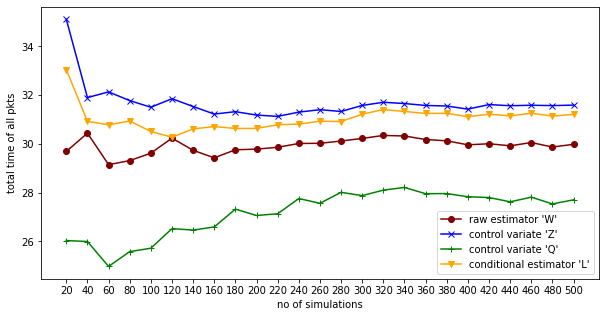

In [139]:
w_bar = []
no_sims = []
for key, val in w_bar_estimator.items():
    w_bar.append(val)
    no_sims.append(key)

z_bar = []
for key, val in z_bar_estimator.items():
    z_bar.append(val)
    
h_bar = []
for key, val in h_bar_estimator.items():
    h_bar.append(val)
    
l_bar = []
for key, val in l_bar_estimator.items():
    l_bar.append(val)

no_sims = np.array(no_sims)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(no_sims.astype('str'), w_bar, color='maroon', marker='o')
plt.plot(no_sims.astype('str'), z_bar, color='blue', marker='x')
plt.plot(no_sims.astype('str'), h_bar, color='green', marker='+')
plt.plot(no_sims.astype('str'), l_bar, color='orange', marker='v')
plt.xlabel('no of simulations') 
plt.ylabel('total time of all pkts')
plt.legend(["raw estimator 'W'", "control variate 'Z'", "control variate 'Q'", "conditional estimator 'L'"], loc="lower right")
  
# displaying the title
plt.title("")
plt.show()

#### (1b) Plot the 90% normalized confidence interval width of the estimators

In [131]:
x = 1.645 # since confidence level is 90%
x_1 = np.array(no_sims)
w_error_ = []
for key, val in sample_var_temp_w.items():
    w_error_.append((val*x)/sqrt(key))

z_error_ = []
for key, val in sample_var_temp_z.items():
    z_error_.append((val*x)/sqrt(key))
    
h_error_ = []
for key, val in sample_var_temp_h.items():
    h_error_.append((val*x)/sqrt(key))
    
l_error_ = []
for key, val in sample_var_temp_l.items():
    l_error_.append((val*x)/sqrt(key))

Text(0.5, 1.0, "estimator 'W' 90% confidence interval")

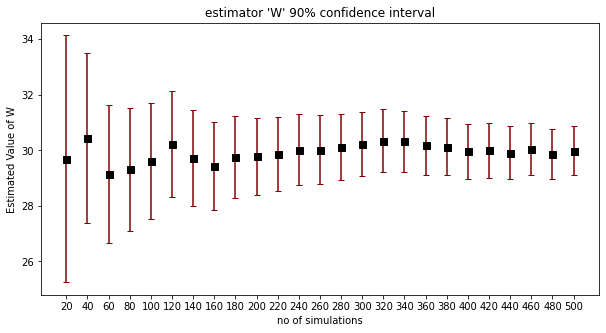

In [140]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.errorbar(x_1.astype('str'), y=w_bar, yerr=w_error_, color="maroon", capsize=3,
             linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
plt.xlabel('no of simulations') 
plt.ylabel('Estimated Value of W')
plt.title("estimator 'W' 90% confidence interval")

Text(0.5, 1.0, "estimator 'Z' 90% confidence interval")

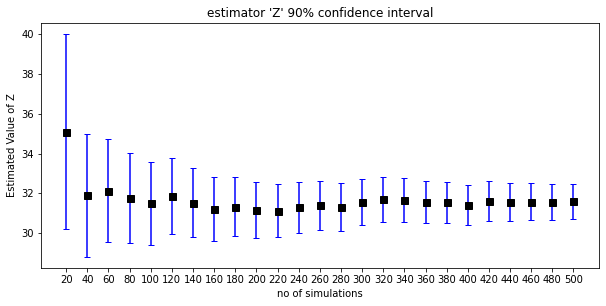

In [147]:
fig, ax = plt.subplots(figsize=(10, 4.5))
plt.errorbar(x_1.astype('str'), y=z_bar, yerr=z_error_, color="blue", capsize=3,
             linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
plt.xlabel('no of simulations') 
plt.ylabel('Estimated Value of Z')
plt.title("estimator 'Z' 90% confidence interval")

Text(0.5, 1.0, "estimator 'H' 90% confidence interval")

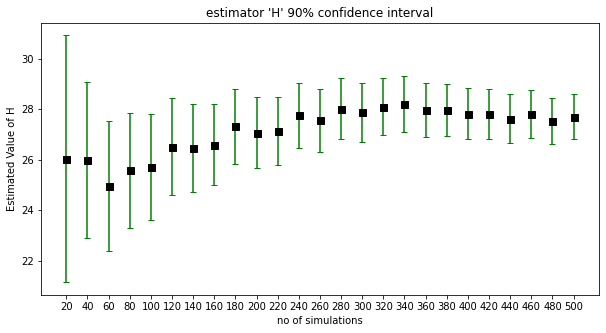

In [148]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.errorbar(x_1.astype('str'), y=h_bar, yerr=z_error_, color="green", capsize=3,
             linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
plt.xlabel('no of simulations') 
plt.ylabel('Estimated Value of H')
plt.title("estimator 'H' 90% confidence interval")

Text(0.5, 1.0, "estimator 'L' 90% confidence interval")

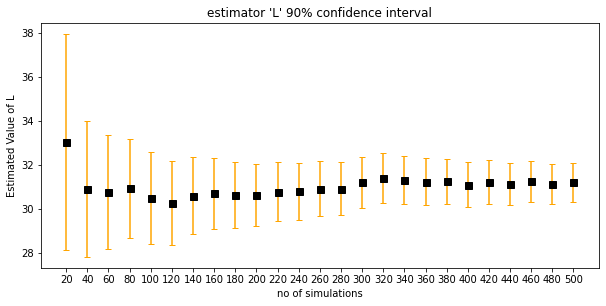

In [150]:
fig, ax = plt.subplots(figsize=(10, 4.5))
plt.errorbar(x_1.astype('str'), y=l_bar, yerr=z_error_, color="orange", capsize=3,
             linestyle="None",
             marker="s", markersize=7, mfc="black", mec="black")
plt.xlabel('no of simulations') 
plt.ylabel('Estimated Value of L')
plt.title("estimator 'L' 90% confidence interval")

#### (2a) Minimum number of simulations required for all 4 estimators

In [151]:
print("Minimum number of simulations needed for estimator W is: ", min(min_sim_w))
print("Minimum number of simulations needed for estimator Z is: ", min(min_sim_z))
print("Minimum number of simulations needed for estimator H is: ", min(min_sim_h))
print("Minimum number of simulations needed for estimator L is: ", min(min_sim_l))

Minimum number of simulations needed for estimator W is:  60
Minimum number of simulations needed for estimator Z is:  40
Minimum number of simulations needed for estimator H is:  80
Minimum number of simulations needed for estimator L is:  40
